## HyDe: a Python Package for Genome-Scale Hybrid Detection



In [1]:
from __future__ import print_function
import phyde as hd

# Import additional libraries for plotting, etc.
import matplotlib.pyplot as plt
import scipy
import numpy as np
import seaborn as sns

In [2]:
%matplotlib inline

### Simulation 1: Hybrid Speciation



In [ ]:
%%bash

# Set the value of gamma, theta, and 
# the number of sites that you want
GAMMA=0.45
THETA=0.1
SITES=50000

# ms sims tree 1: (((p1,hyb),p2),out)
ms 16 $(echo "$SITES * $GAMMA" | bc) -T -I 4 5 5 5 1 \
    -ej 0.25 2 1 -ej 0.5 1 3 -ej 0.75 3 4 | grep '^(' > trees.tre

# ms sims tree 2: ((p1,(hyb,p2)),out)
ms 16 $(echo "$SITES * (1.0 - $GAMMA)" | bc) -T -I 4 5 5 5 1 \
    -ej 0.25 2 3 -ej 0.5 1 3 -ej 0.75 3 4 | grep '^(' >> trees.tre

#seq-gen sims using GTR+I+G
seq-gen -mGTR -s $THETA -l 1 -r 1.0 0.2 10.0 0.75 3.2 1.6 \
    -f 0.15 0.35 0.15 0.35 -i 0.2 -a 5.0 -g 3 -q < trees.tre > seqs.txt


# converting for HyDe..."
python seqgen2matrix.py seqs.txt data.txt map.txt

After simulating your data set (or using the one already provided), we will now read the data into Python using the `HydeData` class. Then we will run two hypothesis tests: one at the population level (`test_triple(...)`) and one at the individual level (`text_individuals(...)`).

In [3]:
data = hd.HydeData("data.txt", "map.txt", "out", 16, 4, 50000)
res1 = data.test_triple('sp1', 'sp2', 'sp3')
res2 = data.test_individuals('sp1', 'sp2', 'sp3')

Reading input file................Done.
Reading map file................Done.


In [4]:
res1

{'Gamma': 0.45940773681124786,
 'Pvalue': 2.220446049250313e-16,
 'Zscore': 8.179342426207114}

In [5]:
res2

{'i10': {'Gamma': 0.46493376377602136,
  'Pvalue': 2.220446049250313e-16,
  'Zscore': 8.132716161034567},
 'i6': {'Gamma': 0.4640608748015547,
  'Pvalue': 0.0,
  'Zscore': 8.345816737520295},
 'i7': {'Gamma': 0.46461907493351406,
  'Pvalue': 0.0,
  'Zscore': 8.651157285765597},
 'i8': {'Gamma': 0.4581442114334961,
  'Pvalue': 1.5543122344752192e-15,
  'Zscore': 7.883091133082527},
 'i9': {'Gamma': 0.4444949954504095,
  'Pvalue': 1.887379141862766e-15,
  'Zscore': 7.8646497195959135}}

Next we'll run a full HyDe analysis with the `hyde_cpp` program using the `run_hyde(...)` function. This will test all possible triples in all directions and will return the result to Python as an object of class `HydeResult`. We will also perform bootstrap resampling on individuals within taxa using the `bootReps` option.

In [6]:
res, boot = hd.run_hyde("data.txt", "map.txt", "out", 16, 4, 50000, bootReps=100)


**  Warning: File 'hyde-out.txt' already exists. **
**  Renaming to 'old-hyde-out.txt'. **


**  Warning: File 'hyde-boot.txt' already exists. **
**  Renaming to 'old-hyde-boot.txt'. **

Number of boot reps: 100


### Plotting

Plotting results with HyDe is done using the Matplotlib and Seaborn modules that we loaded earlier. The `phyde` module has some built in functions for plotting the distributions of the different values in our bootstrap samples. We can also define some generic plotting functions that take a 1-dimensional numpy array of data and plot it using Seaborn.

In [18]:
# Define a few generic plotting functions to make things easier
# down the road
def plot_dist(arr, title, xlab, ylab, col='b'):
    plt.figure(figsize=(14, 11))
    sns.set_style("white")
    ax = sns.distplot(arr, color=col)
    ax.set(ylabel=ylab, xlabel=xlab)
    sns.plt.title(title)
    return ax

def plot_density(arr, title, xlab, ylab):
    plt.figure(figsize=(14, 11))
    sns.set_style("white")
    ax = sns.kdeplot(arr, shade=True, color=col)
    ax.set(ylabel=ylab, xlabel=xlab)
    sns.plt.title(title)
    return ax

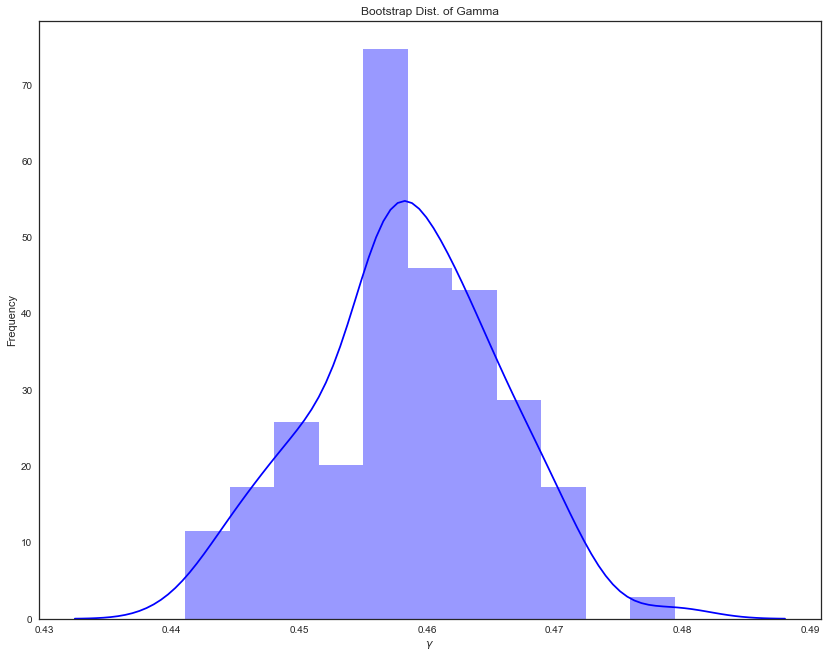

In [19]:
p = hd.viz.dist(boot, "Gamma", "sp1", "sp2", "sp3",
                title="Bootstrap Dist. of Gamma", xlab="$\gamma$", ylab="Frequency")

# Uncomment the line below to save as PDF
#p.figure.savefig("bootstrap-gamma.pdf")

### Simulation 2: F1 Hybrid Individual



In [21]:
%%bash

# Set the value of theta, and 
# the number of sites that you want
THETA=0.1
SITES=50000

# ms sims tree 1: (((p1,hyb),p2),out)
ms 16 $(echo "$SITES * 0.5" | bc) -T -I 5 5 4 1 5 1 -ej 0.25 3 1 -ej 0.25 2 1 \
    -ej 0.5 1 4 -ej 0.75 4 5 | grep '^(' > trees_f1.tre

# ms sims tree 2: ((p1,(hyb,p2)),out)
ms 16 $(echo "$SITES * 0.5" | bc) -T -I 5 5 4 1 5 1 -ej 0.25 3 4 -ej 0.25 2 1 \
    -ej 0.5 1 4 -ej 0.75 4 5 | grep '^(' >> trees_f1.tre

#seq-gen sims using GTR+I+G
seq-gen -mGTR -s $THETA -l 1 -r 1.0 0.2 10.0 0.75 3.2 1.6 \
    -f 0.15 0.35 0.15 0.35 -i 0.2 -a 5.0 -g 3 -q < trees_f1.tre > seqs_f1.txt


# converting for HyDe..."
python seqgen2matrix.py seqs_f1.txt data_f1.txt map_f1.txt

### *Heliconius* Butterflies



In [11]:
heli_res = hd.HydeResult("heliconius-out.txt")
heli_res.res

{('H.m.rosina', 'H.cydno', 'H.timareta'): {'AAAA': 8340360000.0,
  'AAAB': 874840000.0,
  'AABA': 1003670000.0,
  'AABB': 220124000.0,
  'AABC': 266047000.0,
  'ABAA': 637213000.0,
  'ABAB': 100925000.0,
  'ABAC': 92674000.0,
  'ABBA': 162814000.0,
  'ABBC': 135649000.0,
  'ABCD': 6863250.0,
  'BAAA': 902778000.0,
  'BACA': 95771600.0,
  'BCAA': 129761000.0,
  'CABC': 150876000.0,
  'Gamma': 0.341761,
  'Pvalue': 0.0,
  'Zscore': 493.757}}

In [12]:
heli_boot = hd.Bootstrap("heliconius-boot.txt")

Number of boot reps: 20


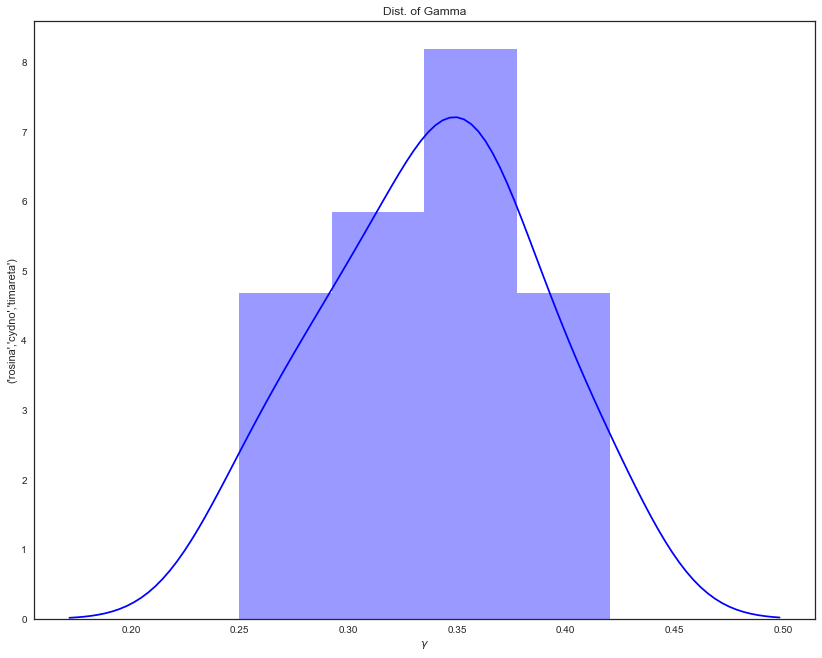

In [13]:
p = hd.viz.dist(heli_boot, "Gamma", "H.m.rosina", "H.cydno", "H.timareta", 
                title="Dist. of Gamma", xlab="$\gamma$", ylab="('rosina','cydno','timareta')")

# Uncomment the line below to save as PDF
#p.figure.savefig("heliconius-gamma.pdf")

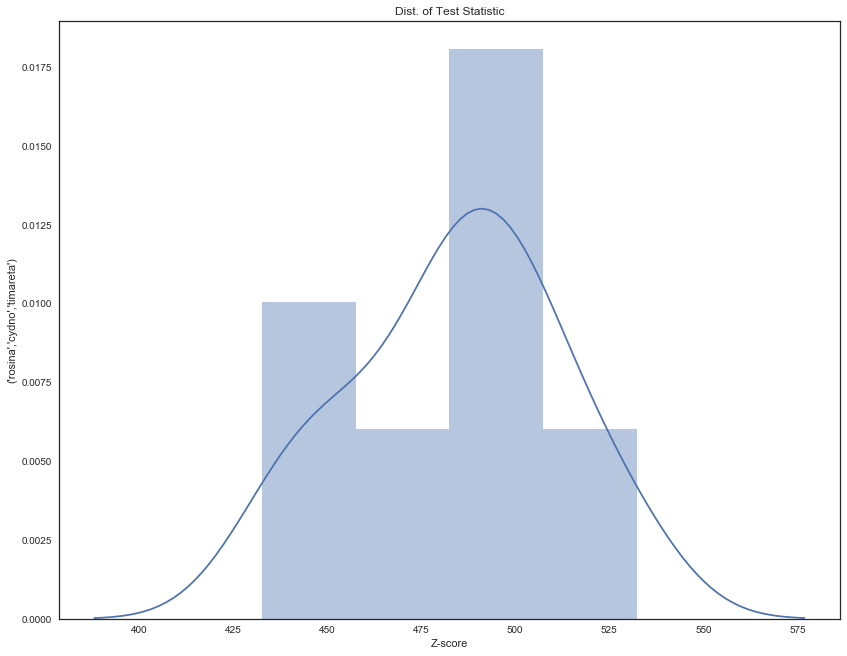

In [17]:
p = plot_dist(np.array(heli_boot("Zscore", "H.m.rosina", "H.cydno", "H.timareta")), 
              title="Dist. of Test Statistic", xlab="Z-score", ylab="('rosina','cydno','timareta')")

# Uncomment the line below to save as PDF
#p.figure.savefig("heliconius-zscore.pdf")

### Swordtail fishes (genus *Xiphophorous*)

In [14]:
res = hd.HydeResult("swordtail-out.txt")

# Filter the results based on P-values
fres1 = {k:v for k,v in res.res.items() if v["Pvalue"] < 9.62e-6}

# Filter the results based on P-values and Gamma
fres2 = {k:v for k,v in res.res.items() if v["Pvalue"] < 9.62e-6 and v["Gamma"] > 0.0 and v["Gamma"] < 1.0}
print(len(res.res), len(fres1), len(fres2))


4599 2910 2058


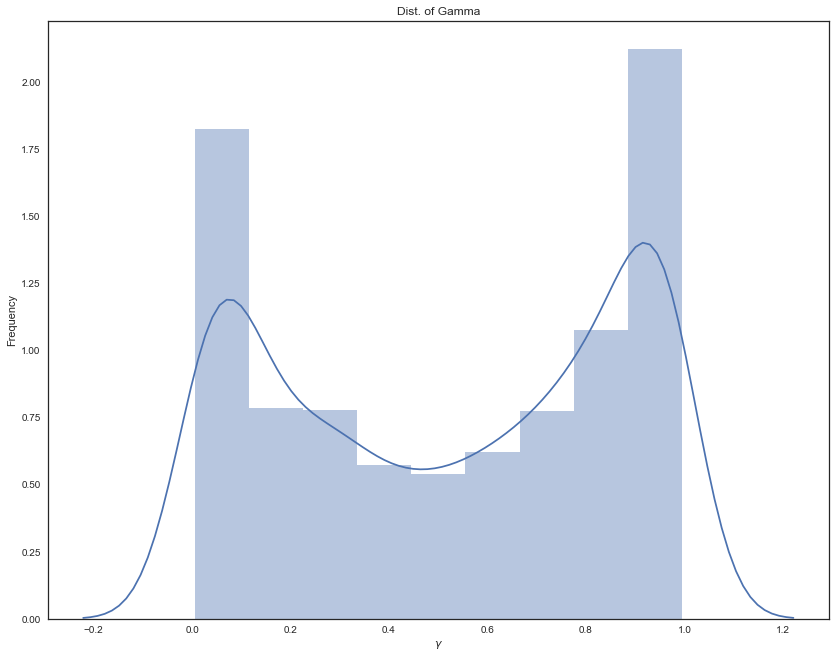

In [15]:
# Since we don't have a Bootstrap object we can just use our generic array plotting fxns
p = plot_dist(np.array([v["Gamma"] for v in fres2.values()]), 
              title="Dist. of Gamma", xlab="$\gamma$", ylab="Frequency")

# Uncomment the line below to save as PDF
#p.figure.savefig("swordtail-gamma.pdf")

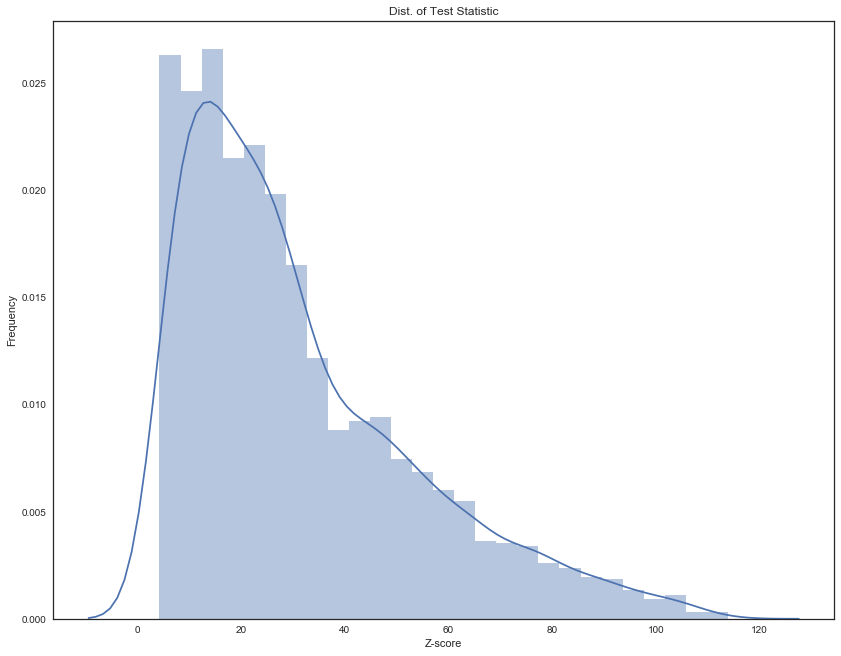

In [16]:
p = plot_dist(np.array([v["Zscore"] for v in fres1.values()]), 
              title="Dist. of Test Statistic", xlab="Z-score", ylab="Frequency")

# Uncomment the line below to save as PDF
#p.figure.savefig("swordtail-zscore.pdf")

#### References

- Cui *et al*. 2013. *Evolution*.
- Kubatko and Chifman. 2015. *bioRxiv*.
- Martin *et al*. 2013. *Genome Research*.